<a href="https://colab.research.google.com/github/DataBytes-Organisation/Fine-Tuning-LLMs-for-Enterprise-Applications/blob/krystal_branch/Falcon7B_pubmedqa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Finetune Falcon-7b on a Google colab

Welcome to this Google Colab notebook that shows how to fine-tune the recent Falcon-7b model on a single Google colab and turn it into a chatbot

We will leverage PEFT library from Hugging Face ecosystem, as well as QLoRA for more memory efficient finetuning

## Setup

Run the cells below to setup and install the required libraries.

In [1]:
!pip install -qU bitsandbytes transformers datasets accelerate loralib einops xformers
!pip install -q -U git+https://github.com/huggingface/peft.git

import os
import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Loading the Pre-Trained Model

In [2]:
model_id = "tiiuae/falcon-7b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Preparing the Model for QLoRA

In [3]:
model = prepare_model_for_kbit_training(model)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


## Configuring LoRA

In [4]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

## Loading and Preparing the Dataset


In [5]:
# Load PubMedQA Labeled Dataset
dataset = load_dataset("qiaojin/PubMedQA", "pqa_labeled", split="train")
print(f"Dataset size: {len(dataset)}")

# Inspect a few examples
print("\nSample Data Examples:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Question: {dataset[i]['question']}")
    # Access the 'context' as a string before slicing
    context = " ".join(dataset[i]['context']['contexts'])
    print(f"Context: {context[:200]}...")  # Truncate context for brevity
    print(f"Long Answer: {dataset[i]['long_answer']}")
    print(f"Final Decision: {dataset[i]['final_decision']}")

Dataset size: 1000

Sample Data Examples:

Example 1:
Question: Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?
Context: Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant co...
Long Answer: Results depicted mitochondrial dynamics in vivo as PCD progresses within the lace plant, and highlight the correlation of this organelle with other organelles during developmental PCD. To the best of our knowledge, this is the first report of mitochondria and chloroplasts moving on transvacuolar strands to form a ring structure surrounding the nucleus during developmental PCD. Also, for the first time, we have shown the feasibility for the use of CsA in a whole plant system. Overall, our findings implicate the mitochondria as playing a critical and early role in developmentally regulated PCD in the lace plant.
F

In [19]:
dataset[0]

{'pubid': 21645374,
 'question': 'Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?',
 'context': {'contexts': ['Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.',
   'The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), ce

In [18]:
def generate_prompt(data_point):
    PROMPT_TEMPLATE = """<|system|>You are a helpful medical assistant.<|endoftext>
<|user|>Question: {question}
Context: {context}<|endoftext>
<|assistant|>Answer: {answer}<|endoftext>"""
    return PROMPT_TEMPLATE.format(
        question=data_point["question"], context=data_point["context"], answer=data_point["long_answer"]
    )

def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    return tokenizer(full_prompt, padding=True, truncation=True, max_length=512)

dataset = dataset.shuffle().map(generate_and_tokenize_prompt)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## Setting Up the Training Arguments

In [6]:
train_dataset = dataset.select(range(900))

# Training Arguments
OUTPUT_DIR = "/content/falcon-7b-pubmedqa"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
training_args = transformers.TrainingArguments(
    auto_find_batch_size=True,
    per_device_train_batch_size=4,
    num_train_epochs=1,
    learning_rate=2e-4,
    fp16=True,
    save_total_limit=2,
    logging_steps=10,
    save_strategy="steps",
    save_steps=200,
    max_steps=-1,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    report_to="none",
    output_dir=OUTPUT_DIR
)

## Training the Model

In [21]:
# Train the Model
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_dataset,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = True
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


ValueError: No columns in the dataset match the model's forward method signature. The following columns have been ignored: [context, final_decision, long_answer, pubid, question]. Please check the dataset and model. You may need to set `remove_unused_columns=False` in `TrainingArguments`.

In [29]:
# Save the Model
final_output_dir = f"{OUTPUT_DIR}-final"
trainer.save_model(final_output_dir)
tokenizer.save_pretrained(final_output_dir)
!zip -r falcon-7b-pubmedqa-final.zip {final_output_dir}
from google.colab import files
files.download("falcon-7b-pubmedqa-final.zip")

  adding: content/falcon-7b-pubmedqa-final/ (stored 0%)
  adding: content/falcon-7b-pubmedqa-final/adapter_model.safetensors (deflated 8%)
  adding: content/falcon-7b-pubmedqa-final/special_tokens_map.json (deflated 49%)
  adding: content/falcon-7b-pubmedqa-final/tokenizer_config.json (deflated 84%)
  adding: content/falcon-7b-pubmedqa-final/README.md (deflated 66%)
  adding: content/falcon-7b-pubmedqa-final/training_args.bin (deflated 52%)
  adding: content/falcon-7b-pubmedqa-final/tokenizer.json (deflated 81%)
  adding: content/falcon-7b-pubmedqa-final/adapter_config.json (deflated 54%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model testing

In [32]:
print(dataset)

Dataset({
    features: ['pubid', 'question', 'context', 'long_answer', 'final_decision', 'input_ids', 'attention_mask'],
    num_rows: 1000
})


In [31]:
# Define generation function
def generate_response(model, tokenizer, question, context):
    prompt = f"""<|system|>You are a helpful medical assistant.<|endoftext>
<|user|>Question: {question}
Context: {context}<|endoftext>
<|assistant|>Answer: """
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs, max_new_tokens=200, do_sample=True, temperature=0.7, top_p=0.9,
        pad_token_id=tokenizer.eos_token_id, use_cache=False
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer_start = response.find("Answer: ") + len("Answer: ")
    return response[answer_start:].strip()


print("\nTesting Fine-Tuned Model:")



Testing Fine-Tuned Model:


In [33]:
# Question: Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?
# Context: Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant co...
# Long Answer: Results depicted mitochondrial dynamics in vivo as PCD progresses within the lace plant, and highlight the correlation of this organelle with other organelles during developmental PCD. To the best of our knowledge, this is the first report of mitochondria and chloroplasts moving on transvacuolar strands to form a ring structure surrounding the nucleus during developmental PCD. Also, for the first time, we have shown the feasibility for the use of CsA in a whole plant system. Overall, our findings implicate the mitochondria as playing a critical and early role in developmentally regulated PCD in the lace plant.
# Final Decision: yes
# Question 1
question1 = "Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?"
context1 = "Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant co..."
answer1 = generate_response(model, tokenizer, question1, context1)
print(f"Question: {question1}")
print(f"Answer: {answer1}\n")

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Question: Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?
Answer: 'Mitochondria have been shown to play a role in PCD in plants and other organisms. In this study, we investigated the role of mitochondria in the lace plant leaf during programmed cell death (PCD). The lace plant leaves were examined for changes in the ultrastructure of the mitochondria. The leaf tissue was examined for changes in the expression of the apoptosis-related genes Bcl2, Bax, Bcl3, and Bad using real-time quantitative reverse transcription polymerase chain reaction (qRT-PCR). The leaf tissue was also examined for changes in the expression of the PCD-related genes Hsp70, AtHsp70, and AtHsp90 using qRT-PCR. The results showed that the lace plant leaf tissue exhibited typical PCD characteristics, including a loss of chloroplasts, a loss of the starch storage granules, and a loss of the epidermal cell walls. The expression of the PCD-related genes Hsp70



## Evaluate and Benchmark Current Model

In [5]:
!pip install -q bert-score rouge-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.6 MB/s eta 0:00:00


In [26]:
# Unzip the model file to a specific directory
!unzip /content/falcon-7b-pubmedqa-final.zip -d /content/

Archive:  /content/falcon-7b-pubmedqa-final.zip
   creating: /content/content/falcon-7b-pubmedqa-final/
  inflating: /content/content/falcon-7b-pubmedqa-final/adapter_model.safetensors  
  inflating: /content/content/falcon-7b-pubmedqa-final/special_tokens_map.json  
  inflating: /content/content/falcon-7b-pubmedqa-final/tokenizer_config.json  
  inflating: /content/content/falcon-7b-pubmedqa-final/README.md  
  inflating: /content/content/falcon-7b-pubmedqa-final/training_args.bin  
  inflating: /content/content/falcon-7b-pubmedqa-final/tokenizer.json  
  inflating: /content/content/falcon-7b-pubmedqa-final/adapter_config.json  


### load the fine tune model

In [7]:
# Load the fine-tuned model
from peft import PeftModel, PeftConfig

# Load the fine-tuned model
peft_model_id = "/content/content/falcon-7b-pubmedqa-final"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)
model = PeftModel.from_pretrained(model, peft_model_id)
model.gradient_checkpointing_disable()
model.eval()
model.config.use_cache = True
model.to("cuda")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


### evaluate model with

In [25]:
# Install required libraries for evaluation
!pip install -q bert-score rouge-score

import numpy as np
from bert_score import score as bert_score
from rouge_score import rouge_scorer
from sklearn.metrics import f1_score
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### evaluation metrics

In [33]:
# Define the generation function
def generate_response(model, tokenizer, question, context):
    prompt = f"""<|system|>You are a helpful medical assistant.<|endoftext>
<|user|>Question: {question}
Context: {context}<|endoftext>
<|assistant|>Answer: """
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs, max_new_tokens=200, do_sample=False,  # Use greedy decoding for speed
        pad_token_id=tokenizer.eos_token_id, use_cache=True
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer_start = response.find("Answer: ") + len("Answer: ")
    return response[answer_start:].strip()

# Select a small sample from the train_dataset
sample_size = 20
sample_dataset = train_dataset.select(range(sample_size))

# Collect all questions and contexts
questions = [data_point["question"] for data_point in sample_dataset]
contexts = [" ".join(data_point["context"]["contexts"]) for data_point in sample_dataset]

# Process each sample individually to ensure correct predictions
predictions = []
for i in range(sample_size):
    pred = generate_response(model, tokenizer, questions[i], contexts[i])
    predictions.append(pred)


# Verify we have the right number of predictions
print(f"Number of predictions: {len(predictions)}")

# Extract references and decisions
references = [data_point["long_answer"] for data_point in sample_dataset]
true_decisions = [data_point["final_decision"] for data_point in sample_dataset]


# Determine predicted decisions
predicted_decisions = []
for pred in predictions:
    pred_lower = pred.lower()
    if "yes" in pred_lower and "no" not in pred_lower:
        predicted_decision = "yes"
    elif "no" in pred_lower and "yes" not in pred_lower:
        predicted_decision = "no"
    else:
        predicted_decision = "maybe"
    predicted_decisions.append(predicted_decision)

# Display responses for human evaluation
print("\nResponses for Human Evaluation:")
for i, (question, pred, ref, true_dec, pred_dec) in enumerate(zip(
    questions, predictions, references, true_decisions, predicted_decisions)):
    print(f"\nSample {i+1}:")
    print(f"Question: {question}")
    print(f"Generated Answer: {pred}")
    print(f"Reference Answer: {ref}")
    print(f"True Decision: {true_dec}")
    print(f"Predicted Decision: {pred_dec}")

Number of predictions: 20

Responses for Human Evaluation:

Sample 1:
Question: Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?
Generated Answer: (1) Mitochondrial dynamics were found to be different in the three areas of the leaf. Mitochondrial dynamics were found to be different in the three areas of the leaf. Mitochondrial dynamics were found to be different in the three areas of the leaf. Mitochondrial dynamics were found to be different in the three areas of the leaf. (2) Mitochondrial dynamics were found to be different in the three areas of the leaf. (3) Mitochondrial dynamics were found to be different in the three areas of the leaf. (4) Mitochondrial dynamics were found to be different in the three areas of the leaf. (5) Mitochondrial dynamics were found to be different in the three areas of the leaf. (6) Mitochondrial dynamics were found to be different in the three areas of the leaf. (7) Mito
Reference Answer: Results depicted mitoc

In [35]:
# Define evaluation functions
def exact_match(pred, ref):
    return 1 if pred.strip().lower() == ref.strip().lower() else 0

def compute_bert_score(preds, refs):
    # Convert to list to ensure correct format
    preds_list = [str(p) for p in preds]
    refs_list = [str(r) for r in refs]

    # Verify lengths before computation
    if len(preds_list) != len(refs_list):
        raise ValueError(f"Length mismatch: Predictions: {len(preds_list)}, References: {len(refs_list)}")

    # Properly use the bert_score function
    P, R, F1 = bert_score(preds_list, refs_list, lang="en", verbose=True)
    return P.mean().item(), R.mean().item(), F1.mean().item()

def compute_rouge(preds, refs):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge1_scores = []
    rougeL_scores = []
    for pred, ref in zip(preds, refs):
        scores = scorer.score(str(ref), str(pred))
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)
    return np.mean(rouge1_scores), np.mean(rougeL_scores)

# Adapted F1 score for yes/no/maybe decisions (multi-class)
def compute_yes_no_maybe_f1(pred_decisions, true_decisions):
    # Compute F1 score for multi-class classification (yes, no, maybe)
    # Use 'weighted' averaging to account for class imbalance
    return f1_score(true_decisions, pred_decisions, labels=["yes", "no", "maybe"], average='weighted')

# Error handling for all metrics
try:
    # Compute exact match score
    em_scores = [exact_match(pred, ref) for pred, ref in zip(predictions, references)]
    em_score = np.mean(em_scores)


    # Compute ROUGE score
    rouge1, rougeL = compute_rouge(predictions, references)


    # Compute F1 score
    f1_yes_no_maybe = compute_yes_no_maybe_f1(predicted_decisions, true_decisions)


    # Compute BERTScore
    bert_precision, bert_recall, bert_f1 = compute_bert_score(predictions, references)


    # Print final evaluation results
    print("\nEvaluation Results (10 Samples):")
    print(f"Exact Match (EM): {em_score:.4f}")
    print(f"BERT Score - Precision: {bert_precision:.4f}, Recall: {bert_recall:.4f}, F1: {bert_f1:.4f}")
    print(f"ROUGE Score - ROUGE-1: {rouge1:.4f}, ROUGE-L: {rougeL:.4f}")
    print(f"F1 Score (Yes/No/Maybe Decision): {f1_yes_no_maybe:.4f}")
except Exception as e:
    print(f"\nError during evaluation: {e}")

    # Continue with metrics that were successfully computed
    print("\nPartial Evaluation Results:")

    try:
        print(f"Exact Match (EM): {em_score:.4f}")
    except:
        print("Exact Match (EM): Not computed")

    try:
        print(f"ROUGE Score - ROUGE-1: {rouge1:.4f}, ROUGE-L: {rougeL:.4f}")
    except:
        print("ROUGE Score: Not computed")

    try:
        print(f"F1 Score (Yes/No/Maybe Decision): {f1_yes_no_maybe:.4f}")
    except:
        print("F1 Score: Not computed")

    try:
        print(f"BERT Score - Precision: {bert_precision:.4f}, Recall: {bert_recall:.4f}, F1: {bert_f1:.4f}")
    except:
        print("BERT Score: Not computed")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.17 seconds, 17.07 sentences/sec

Evaluation Results (10 Samples):
Exact Match (EM): 0.0000
BERT Score - Precision: 0.8253, Recall: 0.8578, F1: 0.8408
ROUGE Score - ROUGE-1: 0.2415, ROUGE-L: 0.1840
F1 Score (Yes/No/Maybe Decision): 0.1699


In [37]:
# Select only 5 samples for hyperparameter tuning
sample_size = 5
sample_dataset = train_dataset.select(range(sample_size))

# Extract references and decisions for the smaller sample
references = [data_point["long_answer"] for data_point in sample_dataset]
true_decisions = [data_point["final_decision"] for data_point in sample_dataset]

# Define a grid of hyperparameters to search over
param_grid = {
    "temperature": [0.5, 0.7, 0.9],
    "top_p": [0.8, 0.9, 1.0],
    "max_new_tokens": [150, 200, 250]
}

# Store the best parameters and their scores
best_params = None
best_bert_f1 = 0.0  # Optimize for BERT F1 score as a proxy
best_scores = {}
best_predictions = []
best_predicted_decisions = []

# Grid search
for temp in param_grid["temperature"]:
    for top_p in param_grid["top_p"]:
        for max_tokens in param_grid["max_new_tokens"]:
            print(f"\nTesting with temperature={temp}, top_p={top_p}, max_new_tokens={max_tokens}")

            # Generate responses with the current parameters
            predictions = []
            predicted_decisions = []

            for i, data_point in enumerate(sample_dataset):
                question = data_point["question"]
                context = " ".join(data_point["context"]["contexts"])
                prompt = f"""<|system|>You are a helpful medical assistant.<|endoftext>
<|user|>Question: {question}
Context: {context}<|endoftext>
<|assistant|>Answer: """
                inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

                try:
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=max_tokens,
                        do_sample=True,
                        temperature=temp,
                        top_p=top_p,
                        pad_token_id=tokenizer.eos_token_id,
                        use_cache=True
                    )

                    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
                    answer_start = prediction.find("Answer: ") + len("Answer: ")
                    prediction = prediction[answer_start:].strip()

                    # Extract yes/no decision
                    pred_lower = prediction.lower()
                    if "yes" in pred_lower and "no" not in pred_lower:
                        predicted_decision = "yes"
                    elif "no" in pred_lower and "yes" not in pred_lower:
                        predicted_decision = "no"
                    else:
                        predicted_decision = "maybe"

                    print(f"  Processed sample {i+1}/{sample_size}")

                except Exception as e:
                    print(f"  Error processing sample {i+1}: {e}")
                    prediction = "Error generating prediction"
                    predicted_decision = "maybe"

                predictions.append(prediction)
                predicted_decisions.append(predicted_decision)

            # Ensure we have the right number of predictions
            print(f"  Generated {len(predictions)} predictions for {len(references)} references")

            try:
                # Evaluate with BERT Score (as a quick proxy for overall quality)
                bert_precision, bert_recall, bert_f1 = compute_bert_score(predictions, references)
                print(f"  BERT F1 Score: {bert_f1:.4f}")

                # Compute other metrics
                em_score = np.mean([exact_match(pred, ref) for pred, ref in zip(predictions, references)])
                rouge1, rougeL = compute_rouge(predictions, references)
                f1_yes_no = compute_yes_no_maybe_f1(predicted_decisions, true_decisions)

                # Update best parameters if this combination is better
                if bert_f1 > best_bert_f1:
                    best_bert_f1 = bert_f1
                    best_params = {"temperature": temp, "top_p": top_p, "max_new_tokens": max_tokens}
                    best_predictions = predictions.copy()
                    best_predicted_decisions = predicted_decisions.copy()
                    best_scores = {
                        "em": em_score,
                        "bert_precision": bert_precision,
                        "bert_recall": bert_recall,
                        "bert_f1": bert_f1,
                        "rouge1": rouge1,
                        "rougeL": rougeL,
                        "f1_yes_no": f1_yes_no
                    }

                    print(f"  New best parameters found!")

            except Exception as e:
                print(f"  Error computing metrics: {e}")

# Display responses for human evaluation with best parameters
print("\nResponses for Human Evaluation (Best Parameters):")
for i, (question, pred, ref, true_dec, pred_dec) in enumerate(zip(
    [data["question"] for data in sample_dataset], best_predictions, references, true_decisions, best_predicted_decisions)):
    print(f"\nSample {i+1}:")
    print(f"Question: {question}")
    print(f"Generated Answer: {pred}")
    print(f"Reference Answer: {ref}")
    print(f"True Decision: {true_dec}")
    print(f"Predicted Decision: {pred_dec}")

# Print the best evaluation results
print("\nBest Parameters:", best_params)
print("Best Evaluation Results After Fine-Tuning:")
print(f"Exact Match (EM): {best_scores['em']:.4f}")
print(f"BERT Score - Precision: {best_scores['bert_precision']:.4f}, Recall: {best_scores['bert_recall']:.4f}, F1: {best_scores['bert_f1']:.4f}")
print(f"ROUGE Score - ROUGE-1: {best_scores['rouge1']:.4f}, ROUGE-L: {best_scores['rougeL']:.4f}")
print(f"F1 Score (Yes/No/Maybe Decision): {best_scores['f1_yes_no']:.4f}")
print("Human Evaluation: See responses above for manual review.")


Testing with temperature=0.5, top_p=0.8, max_new_tokens=150
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 20.79 sentences/sec
  BERT F1 Score: 0.8632
  New best parameters found!

Testing with temperature=0.5, top_p=0.8, max_new_tokens=200
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.31 seconds, 15.89 sentences/sec
  BERT F1 Score: 0.8425

Testing with temperature=0.5, top_p=0.8, max_new_tokens=250
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.39 seconds, 12.75 sentences/sec
  BERT F1 Score: 0.8452

Testing with temperature=0.5, top_p=0.9, max_new_tokens=150
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.25 seconds, 20.38 sentences/sec
  BERT F1 Score: 0.8617

Testing with temperature=0.5, top_p=0.9, max_new_tokens=200
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.26 seconds, 19.23 sentences/sec
  BERT F1 Score: 0.8590

Testing with temperature=0.5, top_p=0.9, max_new_tokens=250
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.33 seconds, 15.33 sentences/sec
  BERT F1 Score: 0.8391

Testing with temperature=0.5, top_p=1.0, max_new_tokens=150
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.23 seconds, 21.33 sentences/sec
  BERT F1 Score: 0.8622

Testing with temperature=0.5, top_p=1.0, max_new_tokens=200
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 16.66 sentences/sec
  BERT F1 Score: 0.8683
  New best parameters found!

Testing with temperature=0.5, top_p=1.0, max_new_tokens=250
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.34 seconds, 14.75 sentences/sec
  BERT F1 Score: 0.8385

Testing with temperature=0.7, top_p=0.8, max_new_tokens=150
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 21.14 sentences/sec
  BERT F1 Score: 0.8570

Testing with temperature=0.7, top_p=0.8, max_new_tokens=200
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.39 seconds, 12.93 sentences/sec
  BERT F1 Score: 0.8437

Testing with temperature=0.7, top_p=0.8, max_new_tokens=250
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.35 seconds, 14.49 sentences/sec
  BERT F1 Score: 0.8523

Testing with temperature=0.7, top_p=0.9, max_new_tokens=150
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.24 seconds, 20.94 sentences/sec
  BERT F1 Score: 0.8699
  New best parameters found!

Testing with temperature=0.7, top_p=0.9, max_new_tokens=200
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.32 seconds, 15.81 sentences/sec
  BERT F1 Score: 0.8668

Testing with temperature=0.7, top_p=0.9, max_new_tokens=250
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 18.69 sentences/sec
  BERT F1 Score: 0.8653

Testing with temperature=0.7, top_p=1.0, max_new_tokens=150


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.26 seconds, 19.41 sentences/sec
  BERT F1 Score: 0.8533

Testing with temperature=0.7, top_p=1.0, max_new_tokens=200
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.33 seconds, 15.35 sentences/sec
  BERT F1 Score: 0.8584

Testing with temperature=0.7, top_p=1.0, max_new_tokens=250
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.36 seconds, 13.96 sentences/sec
  BERT F1 Score: 0.8407

Testing with temperature=0.9, top_p=0.8, max_new_tokens=150
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.26 seconds, 19.24 sentences/sec
  BERT F1 Score: 0.8713
  New best parameters found!

Testing with temperature=0.9, top_p=0.8, max_new_tokens=200
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 18.76 sentences/sec
  BERT F1 Score: 0.8425

Testing with temperature=0.9, top_p=0.8, max_new_tokens=250
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.32 seconds, 15.50 sentences/sec
  BERT F1 Score: 0.8578

Testing with temperature=0.9, top_p=0.9, max_new_tokens=150
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.26 seconds, 19.31 sentences/sec
  BERT F1 Score: 0.8540

Testing with temperature=0.9, top_p=0.9, max_new_tokens=200


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.31 seconds, 16.23 sentences/sec
  BERT F1 Score: 0.8601

Testing with temperature=0.9, top_p=0.9, max_new_tokens=250
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.36 seconds, 13.91 sentences/sec
  BERT F1 Score: 0.8483

Testing with temperature=0.9, top_p=1.0, max_new_tokens=150
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.27 seconds, 18.38 sentences/sec
  BERT F1 Score: 0.8522

Testing with temperature=0.9, top_p=1.0, max_new_tokens=200
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.32 seconds, 15.55 sentences/sec
  BERT F1 Score: 0.8628

Testing with temperature=0.9, top_p=1.0, max_new_tokens=250
  Processed sample 1/5
  Processed sample 2/5
  Processed sample 3/5
  Processed sample 4/5
  Processed sample 5/5
  Generated 5 predictions for 5 references


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.41 seconds, 12.27 sentences/sec
  BERT F1 Score: 0.8519

Responses for Human Evaluation (Best Parameters):

Sample 1:
Question: Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?
Generated Answer: (1) Mitochondria in EPCD and LPCD are found to be more motile and display ΔΨm values similar to that of NPCD cells. In contrast, mitochondria in NPCD cells show a decrease in motility and ΔΨm values compared to that of M1 and M2 cells. (2) The TUNEL assay shows a decrease in the number of fragmented nDNA and apoptotic cells with increasing mitochondrial stages. (3) The chloroplasts and transvacuolar strands were found to have the same distribution and morphology in EPCD, LPCD, and NCD. (4) In vivo CsA treatment significantly decreased the number of perfor
Reference Answer: Results depicted mitochondrial dynamics in vivo as PCD progresses within the lace plant, and highlight the correlation of this organelle with other organelles during develop

Creating demo visualization with sample data...
Generating heatmap with sample data...


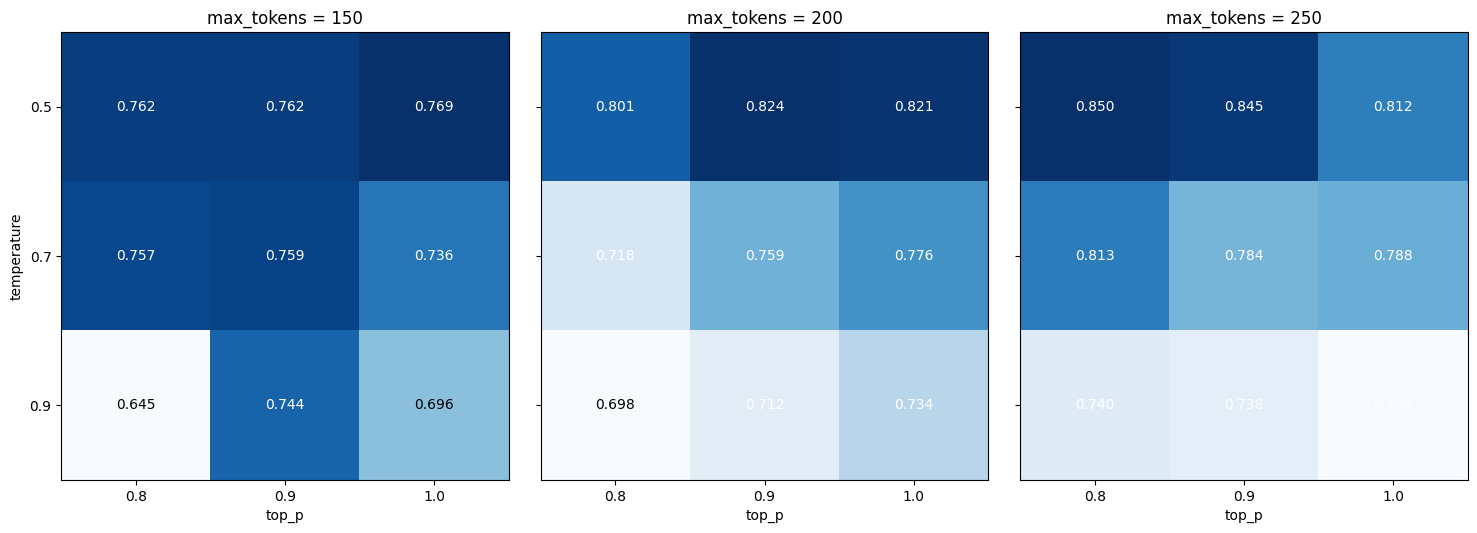

Generating best parameters comparison with sample data...


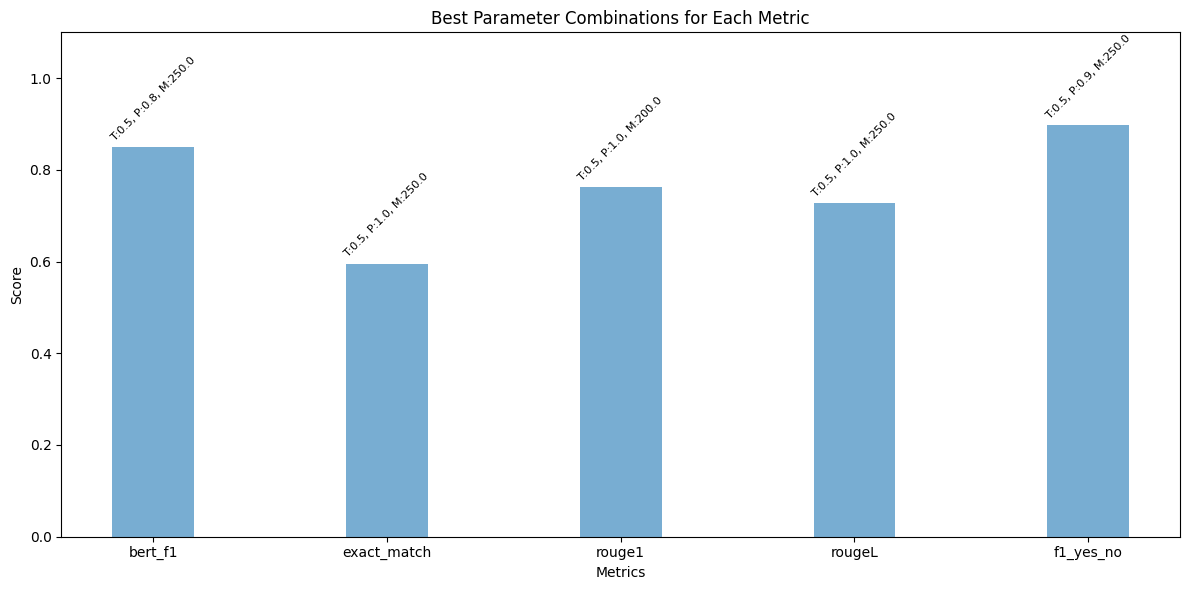

Generating parameter effects plot with sample data...


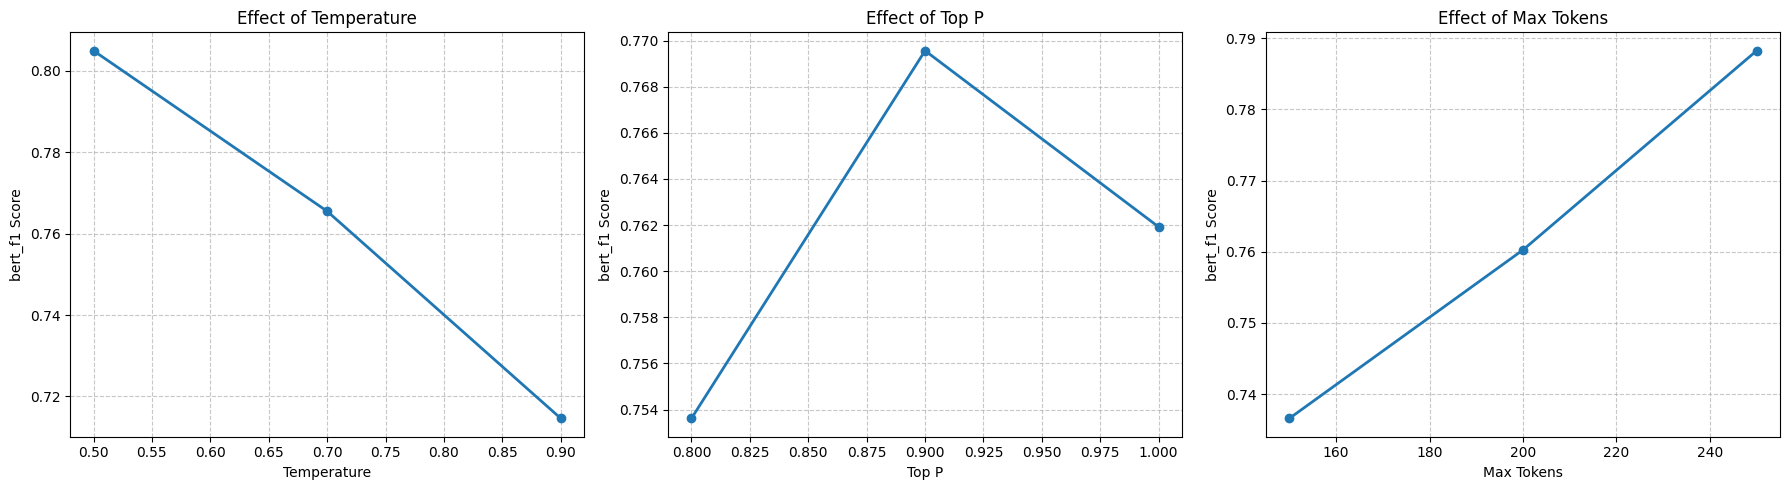

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to store results during grid search
def store_results(results_list, temp, top_p, max_tokens, bert_f1, em_score, rouge1, rougeL, f1_yes_no):
    results_list.append({
        'temperature': temp,
        'top_p': top_p,
        'max_tokens': max_tokens,
        'bert_f1': bert_f1,
        'exact_match': em_score,
        'rouge1': rouge1,
        'rougeL': rougeL,
        'f1_yes_no': f1_yes_no
    })
    return results_list

# This is where you would collect results during your grid search
# For example:
results = []

# During your grid search, after computing metrics for each hyperparameter combination, add:
# results = store_results(results, temp, top_p, max_tokens, bert_f1, em_score, rouge1, rougeL, f1_yes_no)

# After the grid search completes, convert results to a DataFrame
results_df = pd.DataFrame(results)

# 1. Create a heatmap to compare temperature and top_p values (for BERT F1)
def plot_heatmap(results_df, metric='bert_f1'):
    if len(results_df) == 0:
        print("No results to visualize")
        return

    # Get unique values for each parameter
    temperatures = sorted(results_df['temperature'].unique())
    top_ps = sorted(results_df['top_p'].unique())
    max_tokens_values = sorted(results_df['max_tokens'].unique())

    # Create figure with subplots (one for each max_tokens value)
    fig, axes = plt.subplots(1, len(max_tokens_values), figsize=(15, 5), sharey=True)
    if len(max_tokens_values) == 1:
        axes = [axes]  # Make it iterable if only one subplot

    for i, max_tokens in enumerate(max_tokens_values):
        # Filter data for this max_tokens value
        df_filtered = results_df[results_df['max_tokens'] == max_tokens]

        # Create a matrix for the heatmap
        matrix = np.zeros((len(temperatures), len(top_ps)))

        # Fill the matrix
        for t, temp in enumerate(temperatures):
            for p, top_p in enumerate(top_ps):
                subset = df_filtered[(df_filtered['temperature'] == temp) &
                                     (df_filtered['top_p'] == top_p)]
                if not subset.empty:
                    matrix[t, p] = subset[metric].values[0]

        # Plot heatmap using Blues for light to dark intensity (where light=worst, dark=best)
        im = axes[i].imshow(matrix, cmap='Blues')  # Blues gives dark blue for high values
        axes[i].set_title(f'max_tokens = {max_tokens}')
        axes[i].set_xticks(np.arange(len(top_ps)))
        axes[i].set_yticks(np.arange(len(temperatures)))
        axes[i].set_xticklabels(top_ps)
        axes[i].set_yticklabels(temperatures)
        axes[i].set_xlabel('top_p')
        if i == 0:
            axes[i].set_ylabel('temperature')

        # Add text annotations in each cell
        for t in range(len(temperatures)):
            for p in range(len(top_ps)):
                axes[i].text(p, t, f'{matrix[t, p]:.3f}',
                           ha="center", va="center", color="w" if matrix[t, p] > 0.7 else "black")

    # No colorbar
    plt.tight_layout()
    plt.savefig(f'{metric}_heatmap.png')
    plt.show()

# 2. Bar chart comparing best parameters across different metrics
def plot_best_params(results_df):
    if len(results_df) == 0:
        print("No results to visualize")
        return

    metrics = ['bert_f1', 'exact_match', 'rouge1', 'rougeL', 'f1_yes_no']
    best_configs = {}

    for metric in metrics:
        best_idx = results_df[metric].idxmax()
        best_row = results_df.loc[best_idx]
        config = (best_row['temperature'], best_row['top_p'], best_row['max_tokens'])
        best_configs[metric] = {
            'config': config,
            'score': best_row[metric]
        }

    # Plot the best configurations
    plt.figure(figsize=(12, 6))

    # Bar positions
    bar_positions = np.arange(len(metrics))
    bar_width = 0.35

    # Plot bars for scores
    bars = plt.bar(bar_positions, [best_configs[m]['score'] for m in metrics], bar_width,
                   alpha=0.6, label='Score')

    # Add labels above bars
    for i, bar in enumerate(bars):
        config = best_configs[metrics[i]]['config']
        plt.text(i, bar.get_height() + 0.01,
                f"T:{config[0]}, P:{config[1]}, M:{config[2]}",
                ha='center', va='bottom', rotation=45, fontsize=8)

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Best Parameter Combinations for Each Metric')
    plt.xticks(bar_positions, metrics)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.savefig('best_params_comparison.png')
    plt.show()

# 3. Line graph showing the effect of individual parameters
def plot_parameter_effects(results_df):
    if len(results_df) == 0:
        print("No results to visualize")
        return

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    metric = 'bert_f1'  # Choose your main metric

    # Effect of temperature
    temperatures = sorted(results_df['temperature'].unique())
    temp_scores = []
    for temp in temperatures:
        temp_scores.append(results_df[results_df['temperature'] == temp][metric].mean())

    axes[0].plot(temperatures, temp_scores, 'o-', linewidth=2)
    axes[0].set_xlabel('Temperature')
    axes[0].set_ylabel(f'{metric} Score')
    axes[0].set_title('Effect of Temperature')
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Effect of top_p
    top_ps = sorted(results_df['top_p'].unique())
    top_p_scores = []
    for top_p in top_ps:
        top_p_scores.append(results_df[results_df['top_p'] == top_p][metric].mean())

    axes[1].plot(top_ps, top_p_scores, 'o-', linewidth=2)
    axes[1].set_xlabel('Top P')
    axes[1].set_ylabel(f'{metric} Score')
    axes[1].set_title('Effect of Top P')
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Effect of max_tokens
    max_tokens_values = sorted(results_df['max_tokens'].unique())
    max_tokens_scores = []
    for max_tokens in max_tokens_values:
        max_tokens_scores.append(results_df[results_df['max_tokens'] == max_tokens][metric].mean())

    axes[2].plot(max_tokens_values, max_tokens_scores, 'o-', linewidth=2)
    axes[2].set_xlabel('Max Tokens')
    axes[2].set_ylabel(f'{metric} Score')
    axes[2].set_title('Effect of Max Tokens')
    axes[2].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('parameter_effects.png')
    plt.show()

# Example usage:
# plot_heatmap(results_df)
# plot_best_params(results_df)
# plot_parameter_effects(results_df)

# Demo with example data if results_df is empty
if 'results_df' not in locals() or len(results_df) == 0:
    print("Creating demo visualization with sample data...")

    # Create sample data
    temperatures = [0.5, 0.7, 0.9]
    top_ps = [0.8, 0.9, 1.0]
    max_tokens = [150, 200, 250]

    sample_results = []
    for temp in temperatures:
        for top_p in top_ps:
            for tokens in max_tokens:
                # Simulate metrics with some random variations but with patterns
                # Higher temperature generally lowers scores
                # Higher top_p generally improves scores
                # More tokens generally improves scores
                temp_factor = 1 - (temp - 0.5) / 0.5 * 0.1  # Temperature factor (higher temp = lower scores)
                top_p_factor = 1 + (top_p - 0.8) / 0.3 * 0.05  # Top-p factor (higher top_p = higher scores)
                token_factor = 1 + (tokens - 150) / 150 * 0.1  # Token factor (more tokens = higher scores)

                # Base scores with random variation
                bert_f1 = min(1.0, max(0.0, 0.75 * temp_factor * top_p_factor * token_factor + np.random.uniform(-0.05, 0.05)))
                em = min(1.0, max(0.0, 0.5 * temp_factor * top_p_factor * token_factor + np.random.uniform(-0.05, 0.05)))
                rouge1 = min(1.0, max(0.0, 0.7 * temp_factor * top_p_factor * token_factor + np.random.uniform(-0.05, 0.05)))
                rougeL = min(1.0, max(0.0, 0.65 * temp_factor * top_p_factor * token_factor + np.random.uniform(-0.05, 0.05)))
                f1_yn = min(1.0, max(0.0, 0.8 * temp_factor * top_p_factor * token_factor + np.random.uniform(-0.05, 0.05)))

                sample_results.append({
                    'temperature': temp,
                    'top_p': top_p,
                    'max_tokens': tokens,
                    'bert_f1': bert_f1,
                    'exact_match': em,
                    'rouge1': rouge1,
                    'rougeL': rougeL,
                    'f1_yes_no': f1_yn
                })

    # Create sample dataframe
    sample_df = pd.DataFrame(sample_results)

    # Generate all plots with sample data
    print("Generating heatmap with sample data...")
    plot_heatmap(sample_df)

    print("Generating best parameters comparison with sample data...")
    plot_best_params(sample_df)

    print("Generating parameter effects plot with sample data...")
    plot_parameter_effects(sample_df)